In [2]:
# Libraries to import
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm


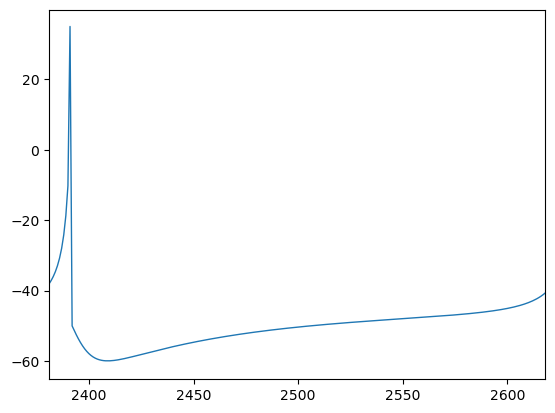

2391.0
2632.0
2634.0


In [3]:
class simple_params:
    '''
    Define the parameter of the Izhikevich model

    C: membrane capacitance
    k: 
    vr: resting membrane potential
    vt: instantaneous threshold potential
    b: amplify current if b < 0, resonant current if b > 0
    '''
    def __init__(self, C, k, vr, vt, a, b, c, d, vpeak):
        self.C = C
        self.k = k
        self.vr = vr
        self.vt = vt
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.vpeak = vpeak


def euler_simple_model(params, h, T, IC, mult_crit, pulse, pulse_idx):
    '''
    euler_simple_model: computes the rheobase at which the neuron fires
    and run multiple simulation with different currents to make sure we have
    at least 6 spikes in our simulation, then run the simulation again

    return: v, a list of floats, membrane potential
            u, a list of floats, recovery current
            peak time
    
    params: a class of simple_params that contains the model parameters
    T: length of oscillation
    h: time step of numerical method
    IC: initial condition of the Izhikevich model
    pulse: perturbation of the current
    pulse_idx: a list of two natural numbers, where the first is the start
    of the index we want to perturb the current at, the the latter is the 
    end of the index we want to perturb the current at
    '''
    # we need to make sure the neuron fire enough number of times
    # and when b is larger, the frequency of firing is larger
    # Ideally, we want to make sure for some b, the neuron fires 5 times

    # Retrieving parameters
    C = params.C
    k = params.k
    vr = params.vr
    vt = params.vt
    a = params.a
    b = params.b
    c = params.c
    d = params.d
    vpeak = params.vpeak
    
    datapoints = int(T/h) # number of samples
    time = np.linspace(0, T * h, datapoints)
    
    # Critical I
    I_b = ((vt - vr)*k + b)**2/(4*k)
    multiplier = np.linspace(0.95, 1.25, 30)
    # If pulse = 0, that means no pertubation
    peak_counter = np.zeros(len(multiplier))
    peak_indices = np.array([])
    peak_time = np.array([])


    if mult_crit == None:
        for idx, mult in enumerate(multiplier):
            I = np.zeros(datapoints)
            I[int(0.2*datapoints):] = (mult) * I_b
            v = np.zeros(datapoints)
            u = np.zeros(datapoints)
            v[0] = IC
            for i, time_i in enumerate(time):
                if i == datapoints - 1:
                    break
                v[i+1] = v[i] + (h/C) * (k*(v[i]- vr)*(v[i]-vt) - u[i] + I[i])
                u[i+1] = u[i] + h*a*(b*(v[i] - vr) - u[i])
                if v[i+1] >= vpeak:
                    v[i] = vpeak
                    peak_time = np.append(peak_time, time_i)
                    peak_indices = np.append(peak_indices, i)
                    v[i+1] = c
                    u[i+1] = u[i+1] + d
            peak_counter[idx] = len(peak_indices)
            peak_time = np.array([])
            peak_indices = np.array([])
    
        max_index = np.where(peak_counter >= 6)
        mult_crit = multiplier[max_index[0][0]]
    else:
        mult_crit = mult_crit 

    # ONLY FOR DEBUGGING PURPOSES
    # print(peak_counter)
    # print(max_index[0])
    # print(max_index[0][0])
    # print(mult_crit)
    # print(peak_counter[max_index[0][0]])
    
    I = np.zeros(datapoints)
    I[int(0.2*datapoints):] = (mult_crit) * I_b
    
    # Perturb the current with pulse
    if pulse != 0:
        I[pulse_idx[0]:pulse_idx[1]] = (mult_crit + pulse) * I_b

    # Define the array again
    peak_indices = np.array([])
    peak_time = np.array([])
    v = np.zeros(datapoints)
    u = np.zeros(datapoints)
    v[0] = IC

    # start simple model simulation using 4th order RK method
    for i, time_i in enumerate(time):
        if i == datapoints - 1:
            break
        k1 = np.array([v[i], u[i]])
        f_k1 = np.array([
            (k * (k1[0] - vr) * (k1[0] - vt) - k1[1] + I[i]) / C,
             a * (b * (k1[0] - vr) - k1[1])
        ])
        k2 = k1 + 0.5 * h * f_k1
        f_k2 = np.array([
            (k * (k2[0] - vr) * (k2[0] - vt) - k2[1] + I[i]) / C,
             a * (b * (k2[0] - vr) - k2[1])
        ])
        k3 = k1 + 0.5 * h * f_k2
        f_k3 = np.array([
            (k * (k3[0] - vr) * (k3[0] - vt) - k3[1] + I[i]) / C,
            a * (b * (k3[0] - vr) - k3[1])
        ])
        k4 = k1 + h * f_k3
        f_k4 = np.array([
            (k * (k4[0] - vr) * (k4[0] - vt) - k4[1] + I[i]) / C,
            a * (b * (k4[0] - vr) - k4[1])
        ])
        update = k1 + h/6 * (f_k1 + 2 * f_k2 + 2 * f_k3 + f_k4)
        
        v[i + 1] = update[0]
        u[i + 1] = update[1]
        # v[i+1] = v[i] + (h/C) * (k*(v[i]- vr)*(v[i]-vt) - u[i] + I[i])
        # u[i+1] = u[i] + h*a*(b*(v[i] - vr) - u[i])
        if v[i+1] >= vpeak:
            v[i] = vpeak
            peak_time = np.append(peak_time, time_i)
            peak_indices = np.append(peak_indices, i)
            v[i+1] = c
            u[i+1] = u[i+1] + d
    # ONLY FOR ILLUSTRATION PURPOSE WHEN RUNNING PRC AND SHOW THE EFFECT OF CURENT PERTURBATION
    # plt.figure()
    # plt.plot(time, I)
    # plt.plot(time, v)
    # plt.title('Typical Perturbation Digram')
    # plt.xlabel('Time (ms)')
    # plt.ylabel('Current (mA)')
    # plt.show()
    
    results = {'v': v,
               'u': u,
               'peak time': peak_time,
               'peak index': peak_indices,
               'time': time,
               'critical multiplier': mult_crit}
    return results

h = 1
T = 8000
pulse = 0
pulse_idx = None
C = 100
k = 0.7
vr = -60
vt = -40
a = 0.03
b = 3
c = -50
d = 100
vpeak = 35
parameters = simple_params(C, k, vr, vt, a, b, c, d, vpeak)
IC = parameters.vr

results = euler_simple_model(parameters, h, T, IC, None,  pulse, pulse_idx)
plt.figure()
plt.plot(range(0, T), results['v'], linewidth = 1)
plt.xlim([2381, 2618])
plt.show()
plt.close()
print(results['peak index'][3])
print(results['peak index'][4])
pulse = 0.2
pulse_idx = [2420, 2425]
results = euler_simple_model(parameters, h, T, IC, None, pulse, pulse_idx)
print(results['peak index'][4])


In [16]:
def PRC_simple_model(params, h, T, IC, perturbation):
    '''
    PRC_simple_model: computes the change in the phase of the Izhikevich model and the corresponding time scale
    when applied a perturbation. 

    params: class simple_params, parameters of the Izhikevich model
    h: 1, time step
    T: Integer larger than 6000, total time for simulation
    IC: floats, inital condition of the Izhikevich model
    perturbation: floats, perturbation applied to the current
    '''
    
    spikes_to_ignore = 3
    PRC = []
    time_PRC = []
    pulse = 0
    pulse_idx = [0, 0]
    IC = params.vr
    mult_crit = None
    ref = euler_simple_model(params, h, T, IC, mult_crit, pulse, pulse_idx) # compute a reference period 
    ref_period_idx = (ref['peak index'][spikes_to_ignore + 1] - ref['peak index'][spikes_to_ignore]).astype(int)
    ref_period_time = ref['peak time'][spikes_to_ignore + 1] - ref['peak time'][spikes_to_ignore]
    peak_idx = np.round(np.linspace(ref['peak index'][spikes_to_ignore], ref['peak index'][spikes_to_ignore + 1])).astype(int)
    # ONLY FOR DEBUGGING PURPOSES
    # print(ref['peak index'][spikes_to_ignore])
    # print(ref['peak index'][spikes_to_ignore + 1])
    # print(peak_idx)
    for idx, val in enumerate(peak_idx):
        pulse = perturbation
        pulse_idx = [val, val + int(ref_period_idx / len(peak_idx))]
        # print(pulse_idx)
        new = euler_simple_model(params, h, T, IC, ref['critical multiplier'], pulse, pulse_idx)
        # ONLY FOR DEBUGGING PURPOSES
        # if idx <= 20:
        #     plt.figure()
        #     plt.plot(new['time'][int(new['peak index'][spikes_to_ignore]):int(new['peak index'][spikes_to_ignore + 1])], 
        #              new['v'][int(new['peak index'][spikes_to_ignore]):int(new['peak index'][spikes_to_ignore + 1])], 'r', label = 'perturbed')
        #     plt.plot(ref['time'][int(ref['peak index'][spikes_to_ignore]):int(ref['peak index'][spikes_to_ignore + 1])], 
        #              ref['v'][int(ref['peak index'][spikes_to_ignore]):int(ref['peak index'][spikes_to_ignore + 1])], 'b', label = 'free running')
        #     plt.xscale('log')
        #     plt.legend()
        #     plt.show()
        
        # Maybe the following using the index of the peaks makes more sense
        phase_change = (ref['peak time'][spikes_to_ignore + 1] 
                 - new['peak time'][spikes_to_ignore + 1]) / ref_period_time
        time_i = (new['time'][val] - ref['peak time'][spikes_to_ignore]) /ref_period_time
        PRC.append(phase_change)
        time_PRC.append(time_i)
    return PRC, time_PRC

h = 0.1
T = 10000
C = 100
k = 0.7
vr = -60
vt = -40
a = 0.03
datapoints = 40
b_array = np.linspace(-2, 5, 40)
b = 100
c = -50
perturbation = 0.02
pdf_name = f'Varying b with less b.pdf'
pdf = PdfPages(pdf_name)
for idx in tqdm(range(datapoints)):
    b = b_array[idx]
    parameters = simple_params(C, k, vr, vt, a, b, c, d, vpeak)
    IC = parameters.vr
    results, time = PRC_simple_model(parameters, h, T, IC, perturbation)
    fig = plt.figure()
    plt.plot(time, results, 'ro', markersize = 2.5)
    plt.plot(time, results, 'blue', linewidth = 1)
    plt.title(f'PRC for b = {round(b, 3)}, perturbation = {perturbation} I_fire')
    plt.xlabel('phase')
    plt.ylabel('change in phase')
    plt.grid()
    pdf.savefig()
    plt.close(fig)
pdf.close()

100%|███████████████████████████████████████████████████████████████████████| 40/40 [40:23<00:00, 60.59s/it]
